# **Modelling Phase with SVM and LSTM of EcoHomeAI**
> **Author:**  Mark, Akshara  
> **Class:** AI43,
> **Project:** Mega Project Group 05- Eco Village Boekel

This notebook contains the Modelling phase of the sensor data provided to us from the client before and after the predictions have been made. We have chosen two algorithms mainly, Support Vector Regressor (SVR) and Long Short Term Memory (LSTM) for predicting air quality index values for the next 7 days. Various tuning methods have been chosen to conduct hyperparameter tuning for finding the right value of hyperparameters. 

# Introduction

Weather forecasting has been a significant area for application of advanced deep learning and machine learning methodologies over traditional methods to improve weather prediction. These new methods are appropriate for processing large chunks of data where massive quantity of historic weather datasets could be utilized for forecasting. This sample showcases two autoregressive methods: one using a deep learning and another using a machine learning framework to predict temperature and Air Quality Index of an ECO-Village.

Idea calculate from this: https://www.breeze-technologies.de/blog/what-is-an-air-quality-index-how-is-it-calculated/

# Importing Necessary Libraries
Firstly importing the required libraries into our notebook.

In [1]:
#For visualizations and plotting graphs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

#Conducting data manipulations
import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML

# Evaluation metrics and instantiator of SVR algorithm
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Building and evaluating LSTM model
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import IPython
import IPython.display
%matplotlib inline

In order to start our model building, we first need to import the datasets. Our client Mr. Ad Vlems has been very kind enough to give us the updated real historical dataset for the months January, February and March. The sensor data has been gathered by the sensor uHoo. In addition, the data storage tool is the local computer's Desktop as a csv format. 

For building our model, we will be using only the last two months for training, as we believe it would have a higher chance of producing higher accuracy result.


In [2]:
Febuary = pd.read_csv('/home/markn/Desktop/DataSensor/FebData.csv')
March = pd.read_csv('/home/markn/Desktop/DataSensor/MarchData.csv')

#Mergining the two months and assigning it to 'bigdatasensor' variable 
bigdatasensor = pd.concat([Febuary, March], ignore_index=True, sort=False)

#Cleaning the dataset by renaming column names
bigdatasensor = bigdatasensor.rename(columns = {'Date and Time': 'dt', 'PM2.5': 'PM25'}, inplace = False)
bigdatasensor['dt'] = pd.to_datetime(bigdatasensor['dt'])

# Adding the underscore in place of the space between two words, with the aim to call the feature easily
bigdatasensor.columns = [c.replace(' ', '_') for c in bigdatasensor.columns]

#Finally, assigning the cleaned and ready to feed dataset to variable 'd'
d = bigdatasensor.copy()

#Printing the final version of the dataset 
bigdatasensor.head()

,dt,Temperature,Relative_Humidity,PM25,TVOC,CO2,CO,Air_Pressure,Ozone,NO2,Virus_Index
0,2021-02-01 09:24:00,7.2,76.5,1,0,712,0,990.6,8.0,19.4,9
1,2021-02-01 09:25:00,8.3,72.3,1,0,704,0,990.5,8.0,19.4,9
2,2021-02-01 09:26:00,9.1,69.3,1,0,668,0,990.6,8.0,19.4,8
3,2021-02-01 09:27:00,9.6,67.0,2,0,639,0,990.5,8.0,19.4,8
4,2021-02-01 09:28:00,9.9,65.2,1,0,618,0,990.6,8.0,19.4,8


In [3]:
# Sort the value follow Datetime ('dt') collumns. 
d.sort_values('dt', inplace=True)

# Air Quality Index Calculation

<center><img src='https://i.imgur.com/GL2BaU4.png'></center>

1. The AQI calculation uses 5 measures: <u>PM2.5, TVOC, NO2, CO2 and O3.</u>
2. For all key parameters the average value in last 24-hrs is used.
3. Each measure is converted into a Sub-Index based on pre-defined groups. Sometimes measures are not available due to lack of measuring or lack of required data points.
4. Final AQI is the maximum Sub-Index with the condition that <u>at least</u> one of PM2.5 and NO2 should be available and <u>at least three out of the five should be available.</u> The reason being, PM2.5 and NO2 were the variables who correlated highly/strongly positive with the target variable.



Check REF: https://www.kaggle.com/rohanrao/calculating-aqi-air-quality-index-tutorial


## Sub Indexing Air Parameters
In this section, we will be calculating the sub index values of each of the important air parameters and adding them as a column in our resulted dataset <b>d</b>. This calculation has been carried out so as to make the values calculated fit to the standard category of AQI.

In [4]:
## PM2.5 Sub-Index calculation

## PM2.5 is measured in ug / m3 (micrograms per cubic meter of air). 
## The predefined groups are defined in the function below:
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

#Adding PM2.5 sub index values onto our dataset
d["PM2.5_SubIndex"] = d["PM25"].apply(lambda x: get_PM25_subindex(x))

## NOx Sub-Index calculation: 
## NOx is measured in ppb (parts per billion). The predefined groups are defined in the function below:
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

d["NOx_SubIndex"] = d["NO2"].apply(lambda x: get_NOx_subindex(x))

## CO Sub-Index calculation
## CO is measured in mg / m3 (milligrams per cubic meter of air). 
## The predefined groups are defined in the function below:

def get_CO2_subindex(x):
    if x <= 700:
        return x * 50 / 700
    elif x <= 800:
        return 50 + (x - 700) * 50 / 100
    elif x <= 1100:
        return 100 + (x - 800) * 100 / 300
    elif x <= 1500:
        return 200 + (x - 1100) * 100 / 400
    elif x <= 2000:
        return 300 + (x - 1500) * 100 / 500
    elif x > 2000:
        return 400 + (x - 2000) * 100 / 500
    else:
        return 0

d["CO2_SubIndex"] = d["CO2"].apply(lambda x: get_CO2_subindex(x))

## TVOC Sub-Index calculation:
def get_TVOCx_subindex(x):
    if x <= 250:
        return x * 50 / 250
    elif x <= 500:
        return 50 + (x - 250) * 50 / 250
    elif x <= 1000:
        return 100 + (x - 500) * 100 / 500
    elif x <= 2500:
        return 200 + (x - 1000) * 100 / 1500
    elif x <= 3000:
        return 300 + (x - 2500) * 100 / 500
    elif x > 3000:
        return 400 + (x - 3000) * 100 / 500
    else:
        return 0

d["TVOCx_SubIndex"] = d["TVOC"].apply(lambda x: get_TVOCx_subindex(x))

## Ozone Sub-Index calculation:
def get_Ozonex_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

d["Ozonex_SubIndex"] = d["Ozone"].apply(lambda x: get_Ozonex_subindex(x))

## Categorizing values to Standard Range

The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and NO2 should be available and at least three out of the five should be available. There is no theoretical upper value of AQI but its rare to find values over 1000.

The pre-defined buckets of AQI are as follows: 

<center><img src='https://i.imgur.com/XmnE0rT.png'></center>


In [5]:
## AQI bucketing with respect to the categories mentioned in the above picture.
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe | Danger"
    else:
        return np.NaN

# The average level of AQI from 1 to 5 index. Arrange from healthy to danger from level 1 to level 5. 
d["Checks"] = (d["PM2.5_SubIndex"] > 0).astype(int) + \
                        (d["TVOCx_SubIndex"] > 0).astype(int) + \
                        (d["NOx_SubIndex"] > 0).astype(int) + \
                        (d["Ozonex_SubIndex"] > 0).astype(int) + \
                        (d["CO2_SubIndex"] > 0).astype(int)


# Finally calculate the AQI from the sub_index. 
d["AQI_calculated"] = round(d[["PM2.5_SubIndex", "NOx_SubIndex",
                                  "CO2_SubIndex", "Ozonex_SubIndex", "TVOCx_SubIndex"]].max(axis = 1))


#Inserting rows with NA is the condition (one of the PM2.5 and NO2) is not met
# d.loc[result["PM2.5_SubIndex"] + result["NOx_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
# d.loc[result.Checks < 3, "AQI_calculated"] = np.NaN

# Convert them into messsage which show in word. By apply the lambda into function above.
d["AQI_bucket_calculated"] = d["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
 
# Check NA. 
d[~d.AQI_calculated.isna()].head(13)
      
d.head(10)

,dt,Temperature,Relative_Humidity,PM25,TVOC,CO2,CO,Air_Pressure,Ozone,NO2,Virus_Index,PM2.5_SubIndex,NOx_SubIndex,CO2_SubIndex,TVOCx_SubIndex,Ozonex_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,2021-02-01 09:24:00,7.2,76.5,1,0,712,0,990.6,8.0,19.4,9,1.666667,24.25,56.000000,0.0,10.0,4,56.0,Satisfactory
1,2021-02-01 09:25:00,8.3,72.3,1,0,704,0,990.5,8.0,19.4,9,1.666667,24.25,52.000000,0.0,10.0,4,52.0,Satisfactory
2,2021-02-01 09:26:00,9.1,69.3,1,0,668,0,990.6,8.0,19.4,8,1.666667,24.25,47.714286,0.0,10.0,4,48.0,Good
3,2021-02-01 09:27:00,9.6,67.0,2,0,639,0,990.5,8.0,19.4,8,3.333333,24.25,45.642857,0.0,10.0,4,46.0,Good
4,2021-02-01 09:28:00,9.9,65.2,1,0,618,0,990.6,8.0,19.4,8,1.666667,24.25,44.142857,0.0,10.0,4,44.0,Good
5,2021-02-01 09:29:00,10.2,64.0,1,0,580,0,990.6,8.0,19.4,6,1.666667,24.25,41.428571,0.0,10.0,4,41.0,Good
6,2021-02-01 09:30:00,10.5,63.1,5,0,542,0,990.6,8.0,19.4,6,8.333333,24.25,38.714286,0.0,10.0,4,39.0,Good
7,2021-02-01 09:31:00,10.6,62.4,3,0,525,0,990.6,8.0,19.4,6,5.000000,24.25,37.500000,0.0,10.0,4,38.0,Good
8,2021-02-01 09:32:00,10.8,61.8,9,0,516,0,990.6,8.0,19.4,6,15.000000,24.25,36.857143,0.0,10.0,4,37.0,Good
9,2021-02-01 09:33:00,10.9,61.3,4,0,508,0,990.5,8.0,19.4,6,6.666667,24.25,36.285714,0.0,10.0,4,36.0,Good


After having calculated the values of Air Quality Index with the standard sub categories, let us try to understand their distribution by plotting them in a bar graph. For this we will be using the SeaBorn library.

/home/markn/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


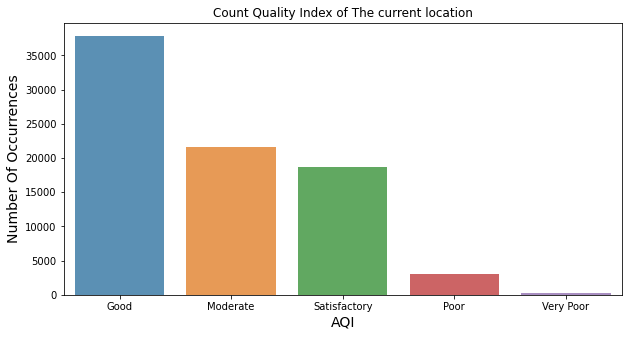

In [6]:
#Extracting the AQI_bucket_calculated category from the dataset
value_index = d['AQI_bucket_calculated'].value_counts() 

#Plotting the Barplot illustrating distribution of AQI categories
plt.figure(figsize=(10,5)) 
sns.barplot(value_index.index, value_index.values, alpha=0.8)
plt.title('Count Quality Index of The current location')
plt.ylabel('Number Of Occurrences', fontsize=14)
plt.xlabel('AQI',fontsize=14)
plt.show()

From the above graph, we can see the distribution of Air Quality is *Good* and *Moderate* telling us that the air remained quite pure and good to breathe for the residents.

# Convert to Timeseries format
The main problem we are trying to solve includes time series so extracting **Hour and Date** from the date column. This dataset is now transformed into a timeseries data format where the Date column is set as the index of the dataset. The reason we extracted hour is to get a hourly understanding of our data values. 


In [7]:
AQI = d.copy()

# Renaming dt to Date 
AQI = AQI.rename(columns = {'dt':'Date'})

# Extract the hour and date
AQI["hour"] = [x.hour for x in AQI["Date"]]

# Extract the date from Date follow Year month day. 
AQI['Date'] = AQI['Date'].dt.strftime('%Y-%m-%d')

Now, grouping the data by the mean of the *Date* and *Hour* column values and dropping the sub indexes, checks, virus index and hour columns calculated above since, we do not require for feeding into our model. In addition, formatting the date column to it's data type and assigning all column values to float for making it easier to fit into the model later. The <b>all_air_index</b> includes all the float values and would be used a function to make the notebook being more easy to read. 

In [8]:
#Grouping by date and hour
AQI = AQI.groupby(['Date', 'hour']).mean().reset_index()

#Dropping the subindex columns
AQI = AQI.drop(['PM2.5_SubIndex', 'NOx_SubIndex', 'CO2_SubIndex', 'TVOCx_SubIndex', 'Ozonex_SubIndex', 'Checks','hour'], axis=1)

#Assigning date column to date time data type
AQI[AQI.columns[0]] = pd.to_datetime(AQI[AQI.columns[0]], format='%Y-%m-%d')
AQI = AQI.set_index(AQI.columns[0]) 
AQI = AQI.sort_index()

# Sortting all column values as a float. 
all_air_index = AQI.astype('float')

all_air_index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1364 entries, 2021-02-01 to 2021-03-31
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        1364 non-null   float64
 1   Relative_Humidity  1364 non-null   float64
 2   PM25               1364 non-null   float64
 3   TVOC               1364 non-null   float64
 4   CO2                1364 non-null   float64
 5   CO                 1364 non-null   float64
 6   Air_Pressure       1364 non-null   float64
 7   Ozone              1364 non-null   float64
 8   NO2                1364 non-null   float64
 9   Virus_Index        1364 non-null   float64
 10  AQI_calculated     1364 non-null   float64
dtypes: float64(11)
memory usage: 127.9 KB


Thus, from above chunk we can confirm that all the numerical column values are float and now lets print the <b>all_air_index</b> dataset. This will be the dataset used to train our two models and eventually forecast values of Air Quality Index.

In [9]:
all_air_index

,Temperature,Relative_Humidity,PM25,TVOC,CO2,CO,Air_Pressure,Ozone,NO2,Virus_Index,AQI_calculated
Date,,,,,,,,,,,
2021-02-01,10.928125,61.328125,3.406250,0.000000,527.812500,0.0,990.562500,7.493750,17.571875,5.812500,37.781250
2021-02-01,17.775000,45.005000,20.975000,10.350000,1034.950000,0.0,990.857500,6.627500,14.567500,5.325000,178.100000
2021-02-01,18.250000,43.955000,13.066667,103.516667,822.450000,0.0,991.105000,2.500000,0.533333,4.033333,106.350000
2021-02-01,19.841667,40.856667,11.016667,112.133333,755.400000,0.0,991.863333,2.500000,0.505000,1.933333,77.716667
2021-02-01,21.178333,37.435000,9.283333,72.283333,698.200000,0.0,992.496667,2.525000,0.478333,3.116667,60.250000
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,25.913333,30.093333,5.283333,247.900000,542.750000,0.0,1017.741667,3.778333,0.491667,5.150000,57.633333
2021-03-31,25.923333,30.143333,5.700000,311.783333,538.500000,0.0,1017.948333,3.386667,0.465000,4.716667,62.416667
2021-03-31,25.273333,30.345000,4.866667,682.350000,550.800000,0.0,1018.138333,3.326667,0.431667,4.916667,128.433333


# Data Splitting and Normalizing
In this section, we will be splitting the data into three subsets, mainly training, validation and testing.**We are splitting our data into 70% training, 20% of validation and the remaining 10% into testing.** 

Data normalization is an essential step while building any machine learning model. In order conduct normalization, we calculate the mean and the standard deviation of only the train set because these are the values through which the model will be learning. Then, subtracting the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [10]:
# This one is a testing split train and test data to observe the normalization 

# The column_indices and name it by i use for every index
column_indices = {name: i for i, name in enumerate(all_air_index.columns)}

#Splitting the data into train, val and test sets
n = len(all_air_index)
train_df = all_air_index[0:int(n*0.7)]
val_df = all_air_index[int(n*0.7):int(n*0.9)]
test_df = all_air_index[int(n*0.9):]


num_features = all_air_index.shape[1]

# Calculate the mean and standardized for normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

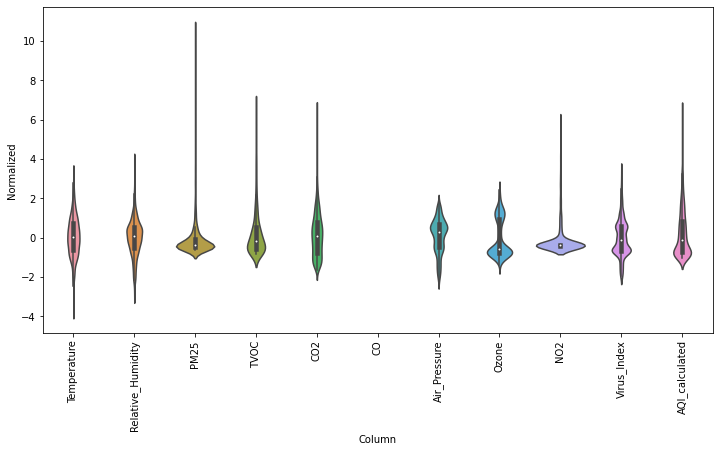

In [11]:
# Apply the plot show to the nomalization of data for each feature.
df_std = (all_air_index - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(all_air_index.keys(), rotation=90)

From the above boxplot, we can see all different features which stay quite normalized after the applied normalization technique. The tail range of PM2.5 is long to the top combine with TVOC and CO2. 
Especially, the CO stays at 0 and it will stay low because the sensor is in the house, and thus there is no sign of fire activity. We don't need to notice this one mainly. Thus now we can confirm that the data is normalized and ready to be put into the modelling phase.

Reference of Normalization Data: https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network

# Model Building

Once the dataset is transformed into a timeseries dataset, it is ready to be used for modelling. In this sample two types of methodology are used for modelling:

1) **Support Vector Machine** - Our first model, is the machine learning algorithm of Support Vector Regression(SVR). The application of SVR in the time series prediction is increasingly popular.

 Neural Networks has good learning capability, but it often causes underfitting and overfitting that the generalization capability becomes weaker. SVM, which is presented by Vapnik etc in 1995,is used more widely in time series at current.

 Different from the traditional statistical learning theory, SVM based on the principle of structural risk minimization can solve the problem of overfitting effectively and has good generality capability and better classification accuracy. So it has a better prospect of application.

2) **LSTM** - Nextly, a deep learning framework of LSTM which uses RNN architecture is used which is appropriate for handling time series data. LSTMs have the promise of being able to learn the context required to make predictions in time series forecasting problems, rather than having this context pre-specified and fixed.

## Support Vector Machine 

Support Vector Machine was first proposed by Vladimir Vapnik as a binary linear classifier in 1963 which was further developed in 1992 to a non linear classifier. This algorithm classifies data by creating hyperplanes between different classes using the maximal margin method. The maximum margin represented as epsilon(ε) is the maximum separation distance(2ε) that can be achieved between the nearest data points of the two classes. These data points which are critical for the hyperplane are known as support vectors.

This study being a regression problem, here its regression variant also known as Support Vector Regression (SVR) is used, which was proposed in 1996 by Vapnik .et.al, suitable for regression in high dimensionality space. The algorithm uses the same maximal margin principle but instead of separating classes it creates a tube with a radius of epsilon(ε) to include the data points. The primary parameters for SVR are the kernel function and its coefficient required to map the data points to a higher dimension space, epsilon(ε) or tube radius, and C or cost as penalty.

We will be using this machine learning algorithm of Support Vector Regression (SVR) to compare performances by the deep learning framework, since it is suitable for fitting high dimensional data with comparatively fewer samples.

Accordingly a function is first created which would first receive the time series data, followed by fitting it using the ML model and forecasting daily for the month of April, 2021.

The support vector regression here uses a radial basis function or rbf as the kernel, a moderate cost value of C=10 and an epsilon of 0.001. These are the critical parameters for the svr model, which can be further tuned for better result. This is then fitted on the train set and predicted on the test set, with accuracy of the fit measured in terms of R-squared.

An illustration of the working on SVM is mentioned below:

<center><img src='https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288454/index2_ub1uzd.png' ></center>



Firstly, we form a function named <b>create_dates</b> which stores our air quality index values and divides them into +1 day sequence. By setting *freq* as D we store the date in the format (Year-Month-Day) and *closed* as right makes the interval closed with respect to the given frequency to the ‘right’ side.

The variable <b>v</b> stores the index of seven_day_forcase. For example we forcast 21 days, 7 days to each of period, it is one of the reason to see in the plot which show for every 7 days period.

In [12]:
# This function makes/stores the day period. 
def create_dates(start,days):
    #create the periods day forward +1 days.
    v = pd.date_range(start=start, periods=days+1, freq='D', closed='right')
    seven_day_forecast = pd.DataFrame(index=v) 
    return seven_day_forecast

Forming the <b>get_value_name</b> function to check if our values contain any NA, and if it does, that row should be dropped and the index will be stored in the *index_name* column.

In [13]:
# Get values, station name and drop null values
def get_value_name(all_air_index,i):
    station_value = all_air_index[[all_air_index.columns[i]]].dropna()
    # If there is any NA it should drop 
    index_name = all_air_index.columns[i]
    # Repeat the index name. 
    return station_value, index_name 

Defining another function train_test_split, which stores the train and test sets and prints the number of rows and columns in each.

In [14]:
# Train-test split for a user input ratio
def train_test_split(value, name, ratio):
    nrow = len(value)
    print(name+' total samples: ',nrow)       # print the number of total samples (row values)
    split_row = int((nrow)*ratio)
    print('Training samples: ',split_row)     # Printing the total training samples
    print('Testing samples: ',nrow-split_row) # Printing the total testing samples
    train = value.iloc[:split_row]
    test = value.iloc[split_row:]
    return train, test, split_row  

Data scaling is essential before feeding it to a LSTM, which helps it train better compared to raw unscaled data. This method scales the train and test data using a minmax scaler from sci-kit learn. This estimator scales and translates each feature individually. Such that it is in the given range on the training set, e.g. between zero and one.


In [15]:
# Data transformation
def data_transformation(train_tract1,test_tract1):
    scaler = MinMaxScaler()
    train_tract1_scaled = scaler.fit_transform(train_tract1)
    # fit_transform() is used on the training data so that we can scale the training data and also learn the scaling parameters of that data. Here, the model built by us will learn the mean and variance of the features of the training set. 
    # These learned parameters are then used to scale our test data.
    test_tract1_scaled = scaler.fit_transform(test_tract1)          
    train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
    test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled,
                                         index = test_tract1.index, columns=[test_tract1.columns[0]])
    return train_tract1_scaled_df, test_tract1_scaled_df, scaler  

Finally one more transformation of feature engineering is required, which is to create new features using lagged values of the time series data itself. Here the number of lag terms could be specified and the function would create lag number of new features using the lagged terms. Lag is again the number of days taken before or the historical data values taken into consideration.


In [16]:
#--Creating features using lagged data. 
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
        # Shift the lag of the day as LSTM, it calculated back from the previous on how many LAG values. 
    return df_copy
    df_copy = df.copy()



Null values resulting from the above feature creation are dropped followed by converting the train and test values to arrays, which is the input data type for LSTM.


### Preprocessing -- Drop Null values and make arrays 
In this preprocessing step, we will be focusing on dropping any null values and storing only the rows with actual values into arrays since neural networks accept data in array format. This is done for all train and test sets.

In [17]:
def make_arrays(train_tract1,test_tract1):
  # Drop an NA value on X_train array if it has the NULL values.
    X_train_tract1_array = train_tract1.dropna().drop(train_tract1.columns[0], axis=1).values
  # Drop an NA value on y_train array if the collumn has NULL values.   
    y_train_tract1_array = train_tract1.dropna()[train_tract1.columns[0]].values
  # Drop an NA values on X_test array if the collumn has NULL values  
    X_test_tract1_array = test_tract1.dropna().drop(test_tract1.columns[0], axis=1).values
  # Drop an NA value on Y_test array if the collumns has NULL values.   
    y_test_tract1_array = test_tract1.dropna()[test_tract1.columns[0]].values    
    return X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array



Model with three hidden layer is created each having a user input number of LSTM memory units, with a dropout rate of 20% for each layer, and a final output dense layer predicting a single value.


### Fitting & Validating using SVR
For fitting and validating the SVR we form another function <b>fit_svr</b>. We have used the R2_score for evaluation because, we are dealing with a regression problem.

In [18]:
def fit_svr(X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array): 
    model_svr = SVR(kernel='rbf', gamma='auto', tol=0.001, C=10.0, epsilon=0.001)
    model_svr.fit(X_train_tract1_array,y_train_tract1_array)            # Check the fit model with X_train, Y_train array
    y_pred_train_tract1 = model_svr.predict(X_train_tract1_array)       # Predict the train set.
    y_pred_test_tract1 = model_svr.predict(X_test_tract1_array)         # Predict the test set

    #Using the score method on the model_svr to calculate the r2_score value of svr model
    print('Test R-squared is: ', round(model_svr.score(X_test_tract1_array,y_test_tract1_array),2)) 
    return model_svr, y_pred_test_tract1   

The forecasted value on the test set using the fitted model is estimated and included with the actual observed temperatures set for visualization

### Validating SVR Results
The support vector regression = SVR, it is use radial basis function or rbs as the kernel, with moderate cost value of C=10, and an epsilon of 0.001. Both are explained in SVM from above definition. It is the critical parameter 
which apply into svr model. It can be further hyper tune for better result. This is then fitted on the train set and predicted on the test set, with accuracy of the fit measure in the term of R-squared. 

Forming a function <b>valid_result_svr</b> which takes the station value which are the different air parameters (temperature, air pressure, humidity and so on) and return the predicted values of SVR algorithm in it's intial form i.e. after inverse transform. The predicted values are stored in the <b>test_tract1_pred</b> variable with the copy() version of the new_test_tract1 array which has the historical data.

In [19]:
def valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, lag):
    new_test_tract1 = station_value.iloc[split_row:] # new_test array was assigned into the number of split row where 20% was split
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    y_pred_test_tract1_transformed = scaler.inverse_transform([y_pred_test_tract1])
    
    # Then y_prediction test trainform apply scaler and inverse_train to, scale back the data to the original representation which belong to the primary data. 
    y_pred_test_tract1_transformed_reshaped = np.reshape(y_pred_test_tract1_transformed,(y_pred_test_tract1_transformed.shape[1],-1))
    test_tract1_pred['Forecast'] = np.array(y_pred_test_tract1_transformed_reshaped)
    return test_tract1_pred

Once the model is validated the fitted model is used to forecast temperature for user input days using past data. This is also estimated using one day walk forward method as mentioned in case of LSTM.


In [20]:
# multi-step future forecast by apply the support vector machine. 
def forecast_svr(X_test_tract1_array, days ,model_svr, lag, scaler):
    last_test_sample = X_test_tract1_array[-1]        
    X_last_test_sample = np.reshape(last_test_sample,(-1,X_test_tract1_array.shape[1]))        
    y_pred_last_sample = model_svr.predict(X_last_test_sample)  
    # support and define the define new_array and predict array 
    new_array = X_last_test_sample
    # Last Step of the sample output in new_array. 
    new_predict = y_pred_last_sample
    # y_prediction last sample output in new_predict
    new_array = X_last_test_sample
    # saving the last test_sample into new_array. 
    new_predict = y_pred_last_sample
    
    # Imagine we have multiple predictions for 7 days period
    seven_days_svr=[]
    
    # Store the prediction data sample into the array. Where it is focusing into the prediction of 7 days of different index.
    for i in range(0,days):               
            new_array = np.insert(new_array, 0, new_predict)                
            new_array = np.delete(new_array, -1)
            new_array_reshape = np.reshape(new_array, (-1,lag))                
            new_predict = model_svr.predict(new_array_reshape)
            temp_predict = scaler.inverse_transform([new_predict])
            # Inverse_trainform as explained: 
            """Undo the scaling of X according to feature_range.
            Parameters
            ----------
            X : array-like of shape (n_samples, n_features)
                Input data that will be transformed. It cannot be sparse.
            After that returns:
            -------
            Xt : ndarray of shape (n_samples, n_features)
                Transformed data.
            """
            seven_days_svr.append(temp_predict[0][0].round(2))
            # Apply function of SVM as the append to add the air index, temp_predict identify air_index after inverse to be round up this float number. 
            
    return seven_days_svr 

All the above methods are finally included in the main function which will take three input of the historical temperature data, number of lag data to be used and the number of days to be forecasted.


In [21]:
def predict_function(all_air_index, lag, days):     
    # What is lag days: Lag the the previous of the history in the time scale. It will have the demonstration in the picture.
    # Where the function SVR or LSTM use the past of the day to gain the future prediction. 
    seven_day_forecast_svr = create_dates('2021-03-30',days)
    # Creat_Dates function 
    for i in range(len(all_air_index.columns)):
        
        # preprocessing
        station_value, index_name = get_value_name(all_air_index,i)       
        train_tract1, test_tract1, split_row = train_test_split(station_value, index_name, 0.80)       
        # it is where the test set is split into the amount of 80%. 
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1)  
        # Data_trainsformation.  With the goal to reproduce the data-frame into the new shape, which apply train and test_tract1. 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df,lag+1)
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)        
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1,
                                                                                                           test_tract1)

        # SVR modeling
        model_svr, y_pred_test_tract1 = fit_svr(X_train_tract1_array, y_train_tract1_array,
                                                X_test_tract1_array, y_test_tract1_array)                       
        test_tract1_pred = valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, lag)        
        seven_days_svr = forecast_svr(X_test_tract1_array, days, model_svr, lag, scaler)            
        seven_day_forecast_svr[index_name] = np.array(seven_days_svr)           
        
        # Plot of scatter plot. 
        plt.figure(figsize=(20,4))
        plt.plot(test_tract1_pred, 'o')
        plt.plot(seven_day_forecast_svr[index_name], color='green', label='forecast', linewidth=4, markersize=12) 
        plt.plot(seven_day_forecast_svr[index_name],'v', markersize=12)
        plt.ylabel('Index - ' + index_name)
        plt.legend(loc='upper right')
        plt.title(index_name + '- April 2021 Forecast')
        plt.xticks(fontsize = 10) 
        plt.show()  
## Accuracy from R-Square-SVR-Test
    return(seven_day_forecast_svr)


Temperature total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.95


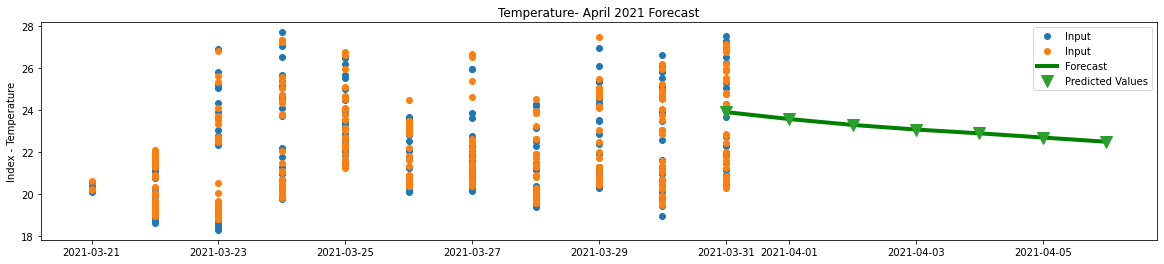

Relative_Humidity total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.86


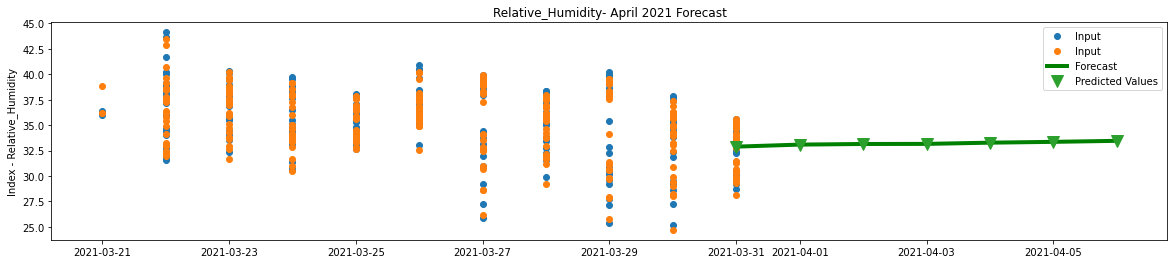

PM25 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.25


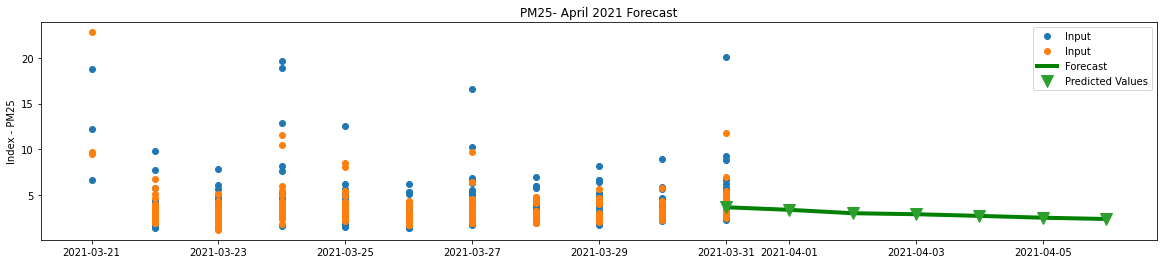

TVOC total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.6


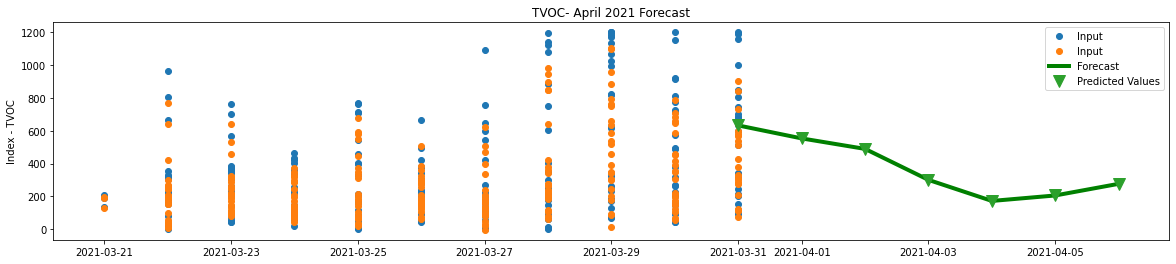

CO2 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.51


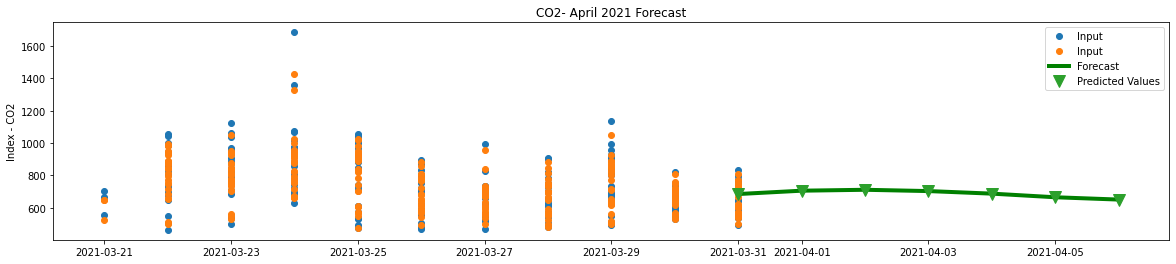

CO total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  1.0


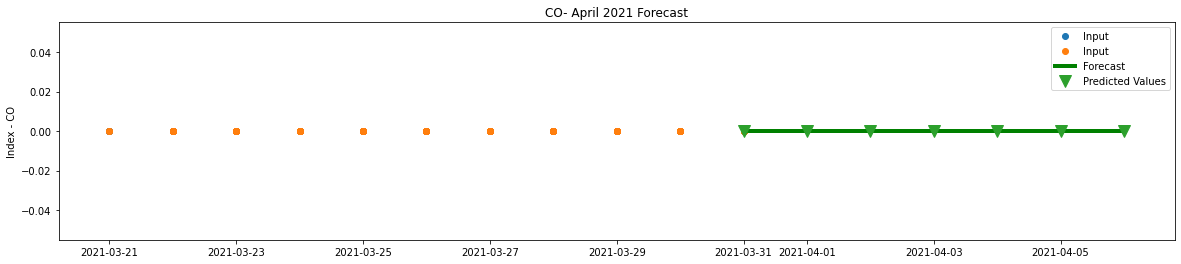

Air_Pressure total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  1.0


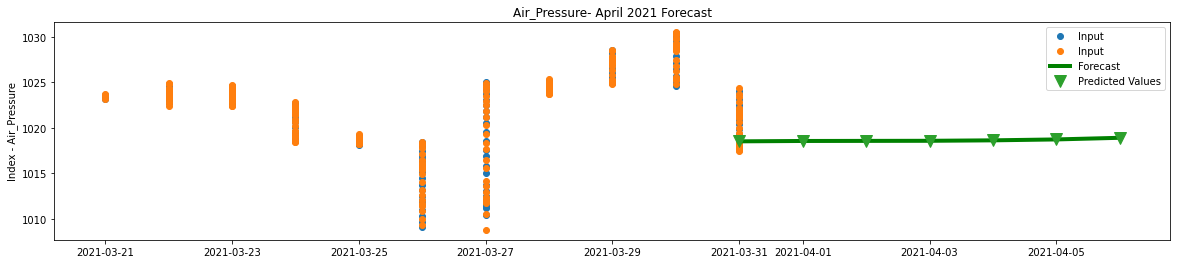

Ozone total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.68


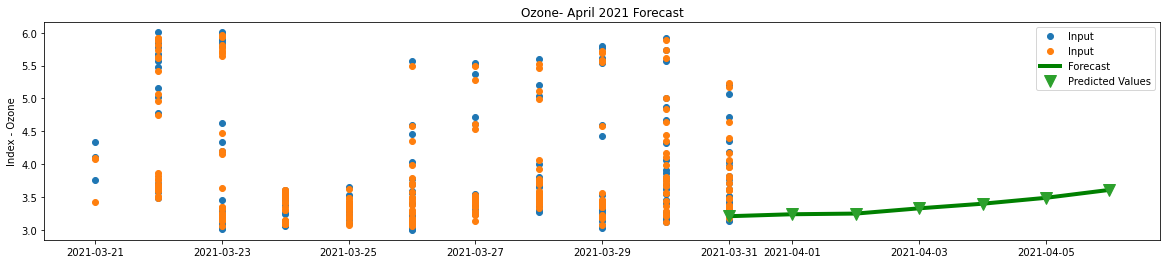

NO2 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.01


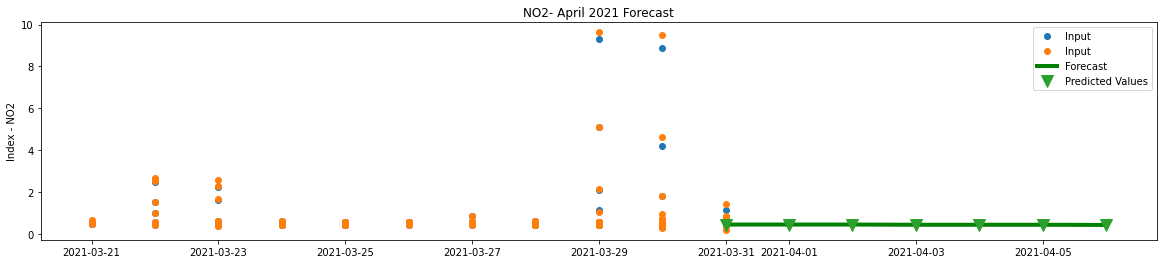

Virus_Index total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.54


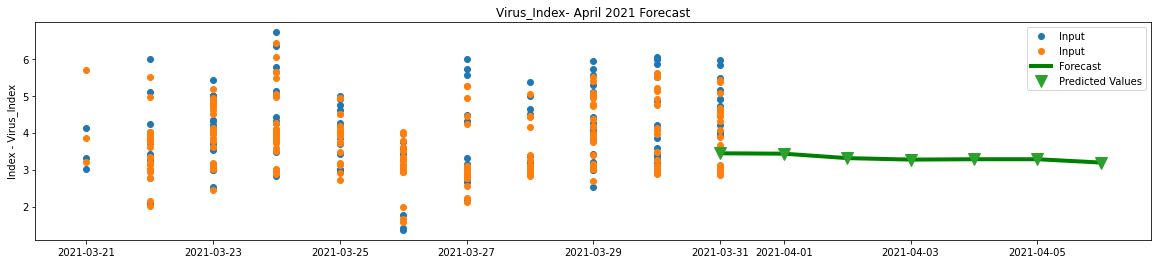

AQI_calculated total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.38


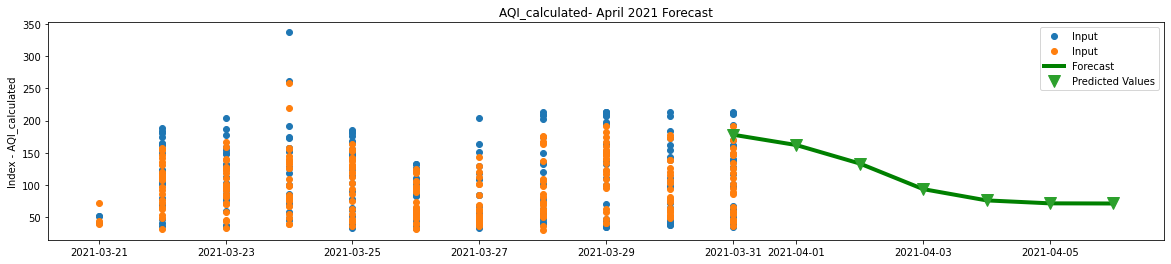

In [22]:
seven_day_forecast_svr = create_dates('2021-03-30',7)
# Creat_Dates function 
for i in range(len(all_air_index.columns)):

    # preprocessing
    station_value, index_name = get_value_name(all_air_index,i)       
    train_tract1, test_tract1, split_row = train_test_split(station_value, index_name, 0.80)       
    # it is where the test set is split into the amount of 80%. 
    train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1)  
    # Data_trainsformation.  With the goal to reproduce the data-frame into the new shape, which apply train and test_tract1. 
    train_tract1 = timeseries_feature_builder(train_tract1_scaled_df,30+1)
    test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, 30+1)        
    X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1,
                                                                                                       test_tract1)

    # SVR modeling
    model_svr, y_pred_test_tract1 = fit_svr(X_train_tract1_array, y_train_tract1_array,
                                            X_test_tract1_array, y_test_tract1_array)                       
    test_tract1_pred = valid_result_svr(scaler, y_pred_test_tract1, station_value, split_row, 30)        
    seven_7_svr = forecast_svr(X_test_tract1_array, 7, model_svr, 30, scaler)            
    seven_day_forecast_svr[index_name] = np.array(seven_7_svr)           

    # Plot of scatter plot. 
    plt.figure(figsize=(20,4))
    plt.plot(test_tract1_pred, 'o', label='Input')
    plt.plot(seven_day_forecast_svr[index_name], color='green', label='Forecast', linewidth=4, markersize=12) 
    plt.plot(seven_day_forecast_svr[index_name],'v', markersize=12, label='Predicted Values')
    plt.ylabel('Index - ' + index_name)
    plt.legend(loc='upper right')
    plt.title(index_name + '- April 2021 Forecast')
    plt.xticks(fontsize = 10) 
    plt.show() 

Temperature total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.95


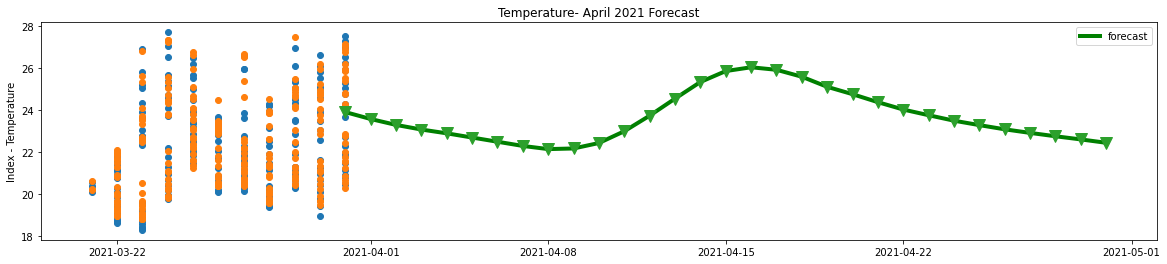

Relative_Humidity total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.86


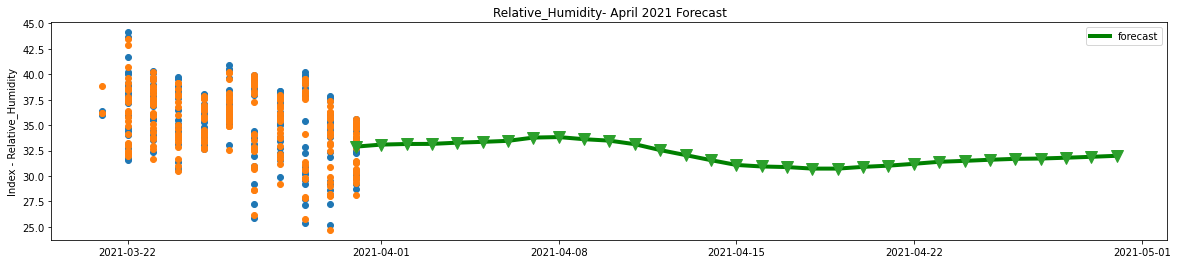

PM25 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.25


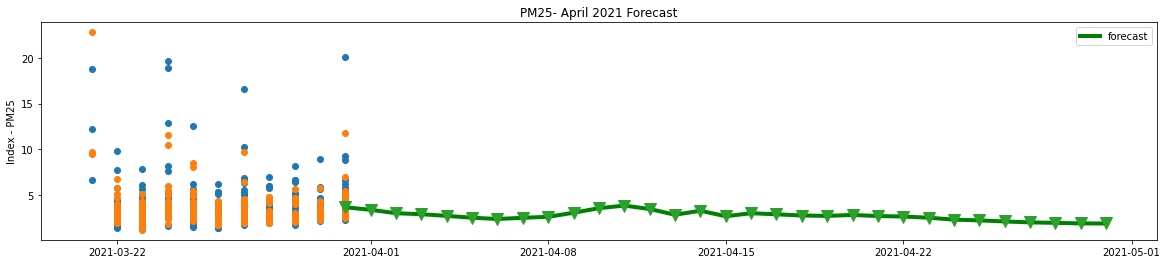

TVOC total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.6


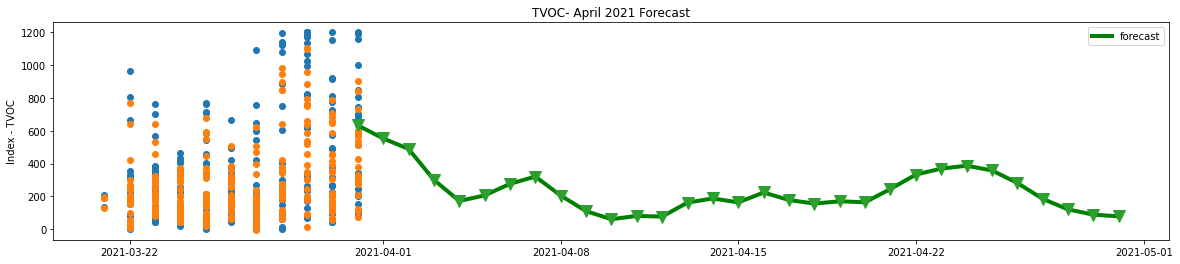

CO2 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.51


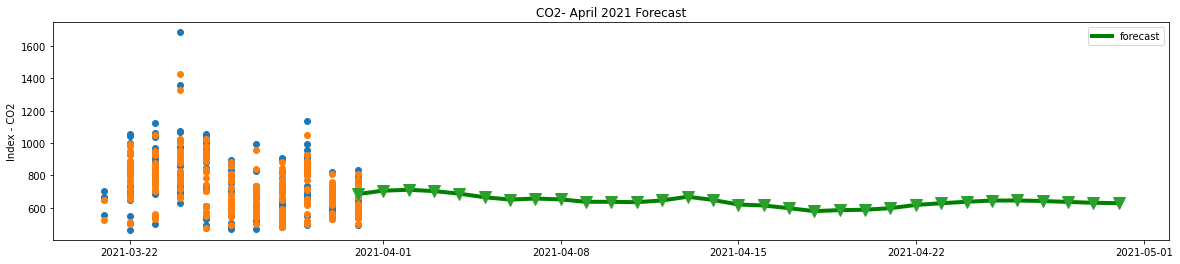

CO total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  1.0


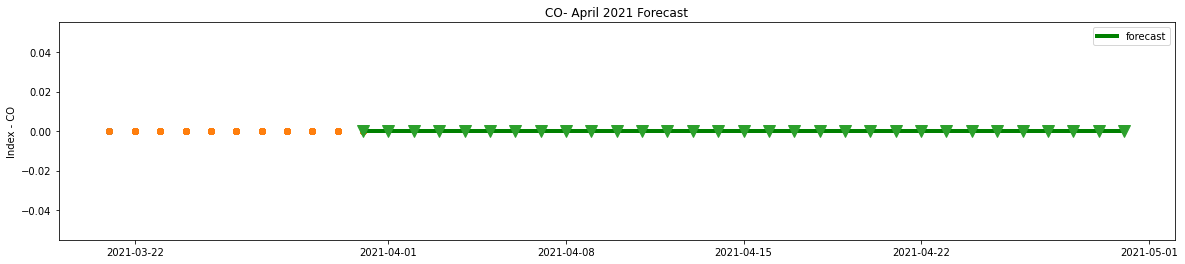

Air_Pressure total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  1.0


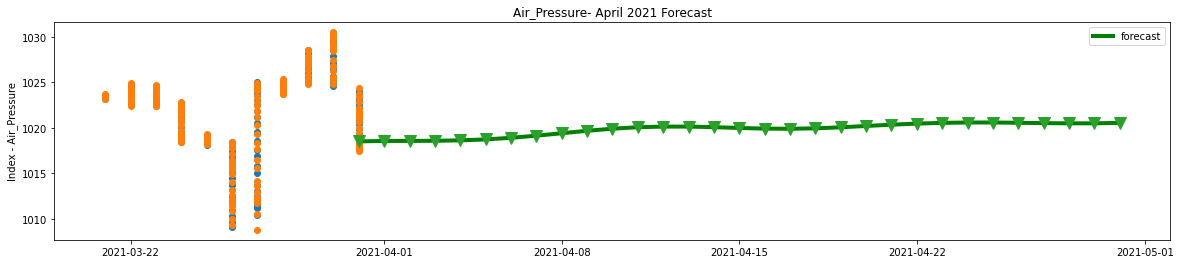

Ozone total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.68


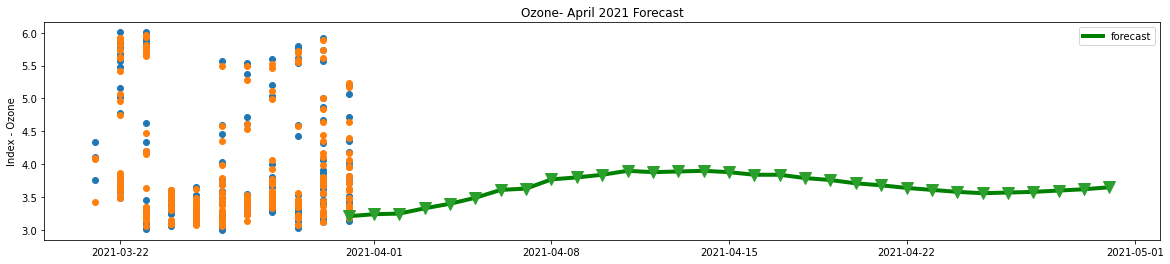

NO2 total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.01


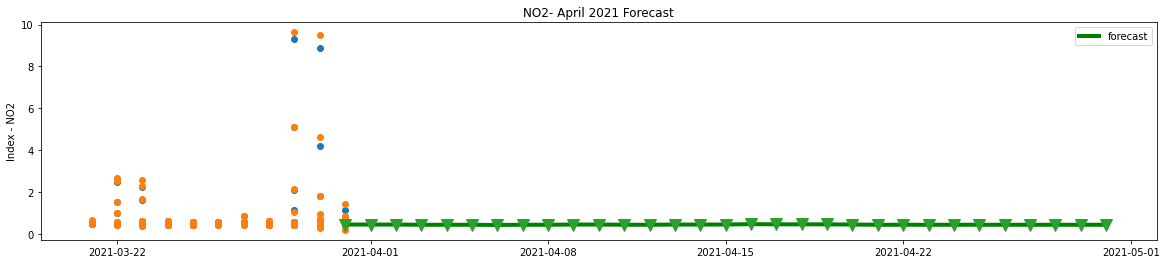

Virus_Index total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.54


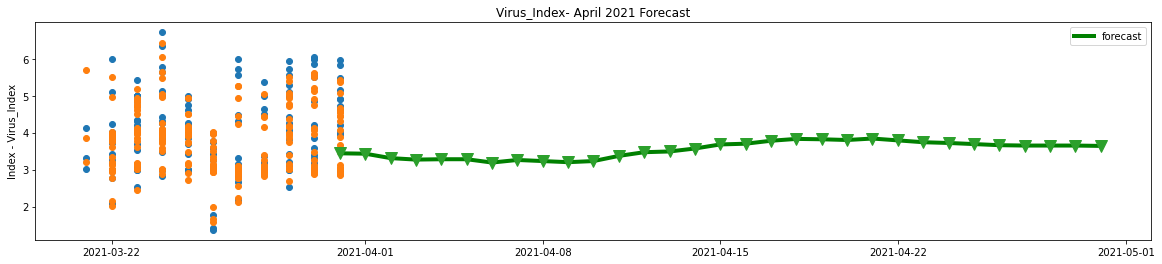

AQI_calculated total samples:  1364
Training samples:  1091
Testing samples:  273
Test R-squared is:  0.38


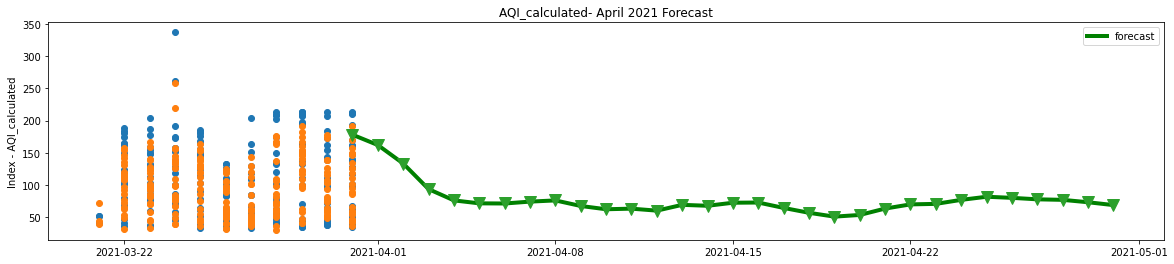

In [23]:
svr_prediction = predict_function(all_air_index, 30, 31)

### Forecast Values with SVM

In [24]:
# Change station names to index
forcast_data_svm = svr_prediction.transpose()
# Make station names to a column
forcast_data_svm_station = forcast_data_svm.reset_index()
forcast_data_svm_station = forcast_data_svm_station.rename(columns={'index':'Station'})
# We tried to pivot the length of output. 

forcast_data_svm_station.head()

,Station,2021-03-31 00:00:00,2021-04-01 00:00:00,2021-04-02 00:00:00,2021-04-03 00:00:00,2021-04-04 00:00:00,2021-04-05 00:00:00,2021-04-06 00:00:00,2021-04-07 00:00:00,2021-04-08 00:00:00,...,2021-04-21 00:00:00,2021-04-22 00:00:00,2021-04-23 00:00:00,2021-04-24 00:00:00,2021-04-25 00:00:00,2021-04-26 00:00:00,2021-04-27 00:00:00,2021-04-28 00:00:00,2021-04-29 00:00:00,2021-04-30 00:00:00
0,Temperature,23.90,23.57,23.29,23.07,22.89,22.69,22.49,22.29,22.14,...,24.37,24.02,23.75,23.49,23.28,23.08,22.91,22.75,22.60,22.44
1,Relative_Humidity,32.89,33.09,33.15,33.16,33.28,33.36,33.46,33.78,33.83,...,31.02,31.20,31.40,31.49,31.60,31.69,31.72,31.80,31.89,31.99
2,PM25,3.70,3.42,3.05,2.94,2.76,2.56,2.42,2.55,2.66,...,2.74,2.69,2.56,2.35,2.27,2.15,2.05,2.00,1.94,1.93
3,TVOC,632.29,553.19,489.26,300.39,172.26,205.63,276.58,320.56,205.25,...,245.18,332.89,369.14,386.94,358.19,282.14,185.15,120.68,88.74,78.18
4,CO2,684.64,705.30,710.92,702.90,687.10,664.69,650.37,656.78,651.37,...,597.41,617.12,627.53,636.89,644.14,644.92,641.50,635.93,630.44,628.24


### Export SVM Model to Json. 

In [25]:
# svr_prediction.to_csv('Export_DataFrame.CSV')

# svr_prediction.to_json ('Export_DataFrame.json')

The reason it has exported to Json is to deploy into the web application. 

## LSTM 
LSTM (Long short-term memory) first proposed by Hochreiter & Schmidhuber, is a type of Recurrent Neural Network(RNN). RNN could be defined as a special kind of neural network which can retain information from past inputs which is not possible for traditional neural networks. This makes it suitable for forecasting timeseries data wherein prediction is done based on past data. LSTM is built of units, each consisting of four neural networks, which are used to update its cell state using information from new inputs and past outputs.

A function is created here which encapsulates the steps for processing and predicting from the timeseries data.

First an empty datetime DataFrame is created for the number of days the temperature , other index is to be forecasted, where future predicted values will be stored.

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png)







### Building the Structure
For our neural network, we will be first starting with building our model. For this, we define a functions <b>lstm_model</b>. We are defining a sequential model, meaning there will be sequence of layers with the input layers with shape (trainX.shape[1],trainX.shape[2]). 
By setting kernel_initialier as 'lecun_uniform', the initialization of the kernel sets initial random weights of Keras layer. 

Consequently, we added `DropOut Layer` as it samples and drops inputs which are already learnt from the model in earlier layers. Dropout layer between the input (or visible layer) and the first hidden layer. The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle.   

`Return_sequences = True` means, LSTM model will store/learn the output of our inputs one by one. This allows the model to take the output at each step (after each window sequence). The output will be a sequence of the same length, with return_sequence=FALSE, the output will be just one vector.

The number of `epochs` is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.
The `batch size` is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. Here we use a batch size of 120 because after experimenting with a batch size of 32, 64 and 120, the following batch resulted in a better performance.

In [26]:
# Define LSTM model
def lstm_model(units, trainX, testX, y_train_tract1_array, y_test_tract1_array):
    model = Sequential()
    model.add(LSTM(units,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]),kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.2))  
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(0.2))    
    model.add(LSTM(units))
    model.add(Dropout(0.2))
    model.add(Dense(1))   # Dense is the output layer. We have 1 magnitude because we are predicting 1 variables which is 1 air_quality index

    #Compiling the model with adam optimizer because it's known for it's strong ability to outperform the other optimizers with a
    #Learning Rate around 0.001. To keep the minimum learning rate. Consequently, to lower the loss values.
    # The more learning rate the more it effect to the loss. 
    # Check the complie base on Adam - Giving the loss value in Mean_square_error. 
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error') 
    
    
    #Fitting the model and running in on 100 epochs in 120 batch size.
    model.fit(trainX, 
              y_train_tract1_array, 
              batch_size=120, 
              epochs=100, 
              validation_data=(testX, y_test_tract1_array), 
              verbose=0)
    return model

### Validating LSTM Results

In the validation method, the fitted model is used here to predict on the test set and the results are added to a column called Forecast for visualization. The accuracy of the predicted result is measured by r-square method, to check its similarity with the actual temperature readings, which is intuitive to interpret.

In [27]:
def valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag):    
    testPredict = model.predict(testX)
    # Predict for TextX , the test set is just use to compare to have the score of R-squared. 
    rSquare_test = r2_score(y_test_tract1_array, testPredict)
    print('Test R-squared is: %f'%rSquare_test)  
    testPredict = scaler.inverse_transform(testPredict)        
    new_test_tract1 = station_value.iloc[split_row:]       
    test_tract1_pred = new_test_tract1.iloc[lag:].copy()
    test_tract1_pred['Forecast'] = testPredict
    return test_tract1_pred 

# Multi step future forecast for next days number of days. 

## Hyper Tunning and Forecast

In [28]:
def forecast(model, testX, test_tract1, lag, scaler, days):
    seven_days = []
# The array to store seven day index. 
    new0 = testX[-1]        
    last = test_tract1.iloc[-1]
    new_predict = last[0]        
    new_array = np.insert(new0, 0, new_predict)        
    new_array = np.delete(new_array, -1)
    new_array_reshape = np.reshape(new_array, (-1,1,lag))       
    new_predict = model.predict(new_array_reshape)
    temp_predict = scaler.inverse_transform(new_predict) 
    seven_days.append(temp_predict[0][0].round(2))
    
    for i in range(1,days):
        new_array = np.insert(new_array, 0, new_predict)             
        new_array = np.delete(new_array, -1)
        new_array_reshape = np.reshape(new_array, (-1,1,lag))            
        new_predict = model.predict(new_array_reshape)
        temp_predict = scaler.inverse_transform(new_predict) 
        seven_days.append(temp_predict[0][0].round(2))
    return seven_days   

LSTM model with three hidden layer is created each having a user input number of LSTM memory units, with a dropout rate of 20% for each layer, and a final output dense layer predicting a single value. And we will be making future predictions from 2021-3-31 date for seven consecutive days onwards.


In [29]:
def index_air_lstm(all_air_index, lag, days):    
    # The forecast progression will start from the current choosen day, which force to the future of seven day. 
    seven_day_forecast_lstm = create_dates('2021-3-31',days) 
    
    for i in range(len(all_air_index.columns)):
        
        # Preprocessing data 
        station_value, index_name = get_value_name(all_air_index,i)        
        train_tract1, test_tract1, split_row = train_test_split(station_value, index_name, 0.80)        
        train_tract1_scaled_df, test_tract1_scaled_df, scaler = data_transformation(train_tract1,test_tract1) 
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df, lag+1) 
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)               
        X_train_tract1_array, y_train_tract1_array, X_test_tract1_array, y_test_tract1_array = make_arrays(train_tract1, 
                                                                                                           test_tract1) 
        # Reshaping the training set to fit in the array format accepted by the neural network       
        trainX = np.reshape(X_train_tract1_array, (X_train_tract1_array.shape[0],1,X_train_tract1_array.shape[1]))
        testX = np.reshape(X_test_tract1_array, (X_test_tract1_array.shape[0],1,X_test_tract1_array.shape[1]))                
        
        # LSTM modelling & forecast
        model = lstm_model(20, trainX, testX, y_train_tract1_array, y_test_tract1_array)             
        test_tract1_pred = valid_result(model, testX, y_test_tract1_array, scaler, station_value, split_row, lag)        
        seven_days = forecast(model, testX, test_tract1, lag, scaler, days)       
        seven_day_forecast_lstm[index_name] = np.array(seven_days)       
        
        # plot result
        plt.figure(figsize=(20,5))
        plt.plot(test_tract1_pred, 'o')     
        # Make the marker with scatter plot. 
        plt.plot(seven_day_forecast_lstm[index_name], color='blue', label='forecast',linewidth=4, markersize=12 ) 
        plt.plot(seven_day_forecast_lstm[index_name],'v', markersize=12)
        # Make the marker with V with it size. 
        plt.ylabel('AirIndex')
        plt.legend(loc='upper right')
        plt.title(index_name + '- April 2021 Air Forecast Quality')
        plt.show()        
        
    return(seven_day_forecast_lstm)

# Model Comparison and Evaluation
The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. In general, the higher the R-squared, the better the model fits your data. 

Temperature total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.826897


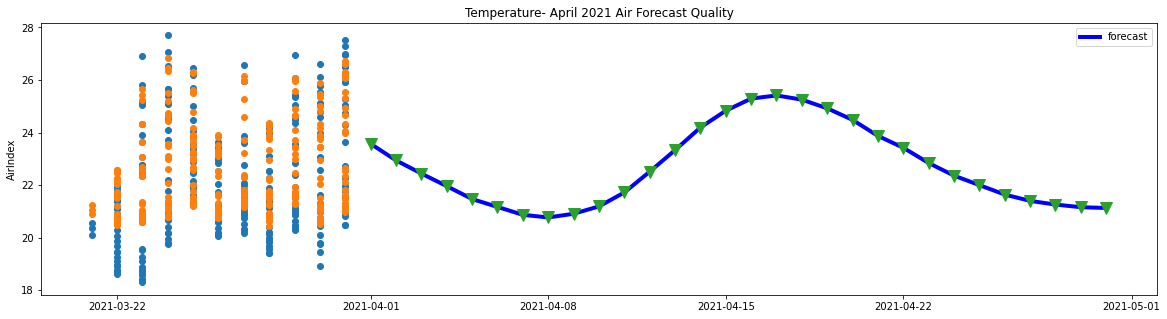

Relative_Humidity total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.745942


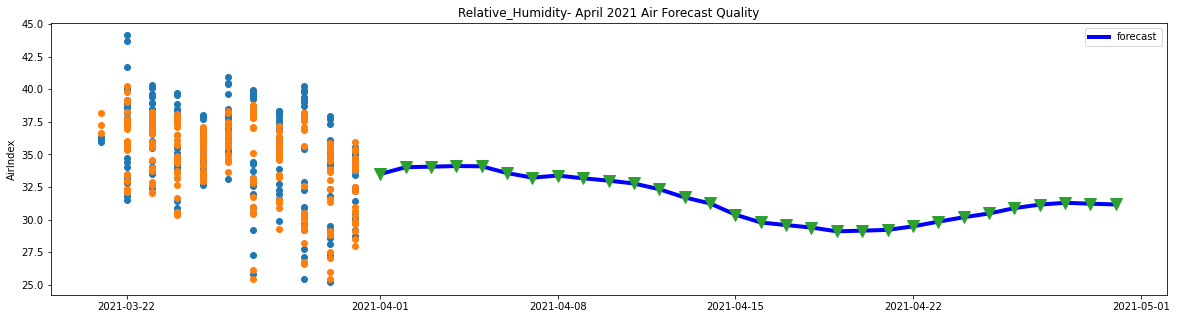

PM25 total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.205030


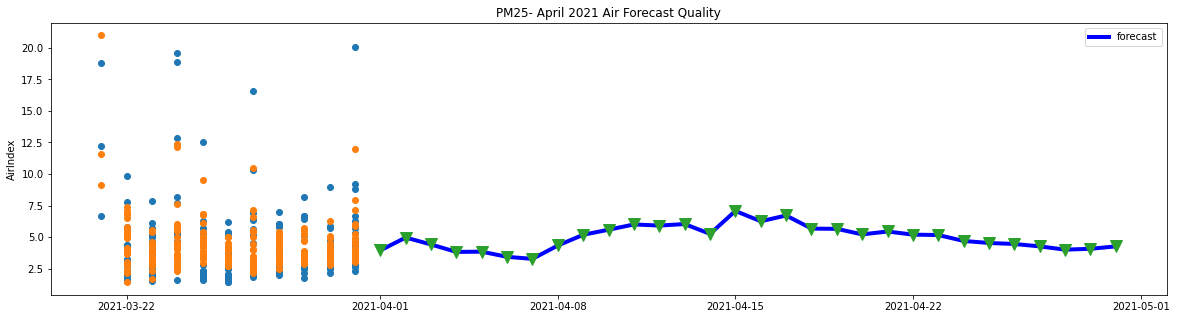

TVOC total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.551873


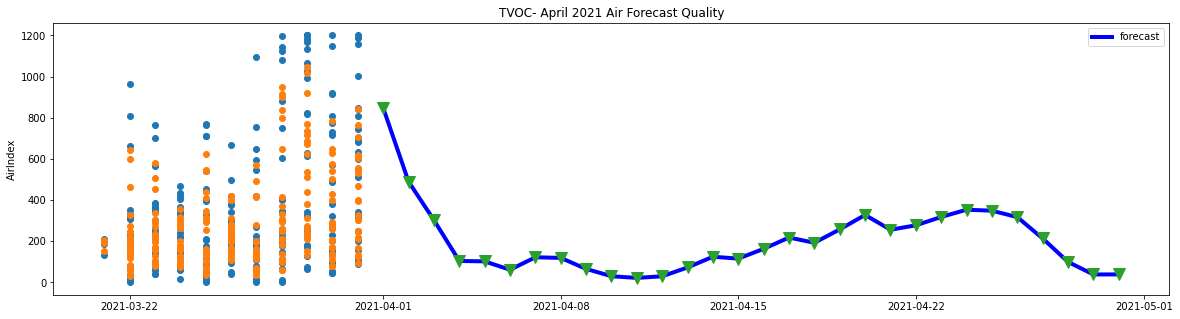

CO2 total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.500385


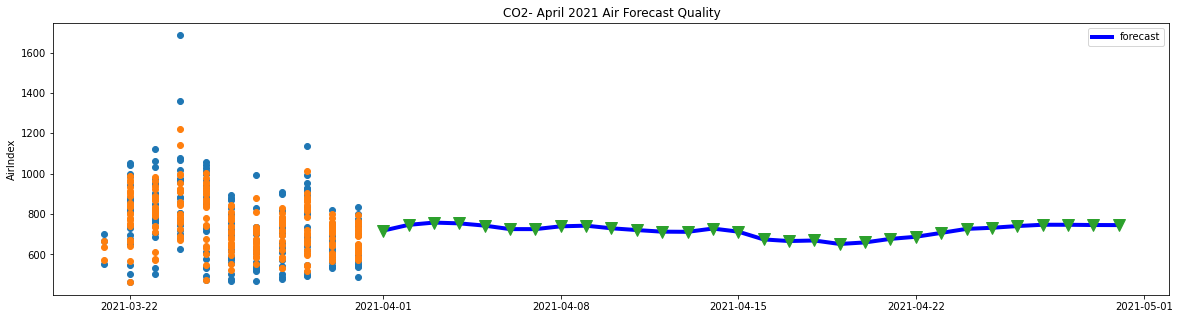

CO total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 1.000000


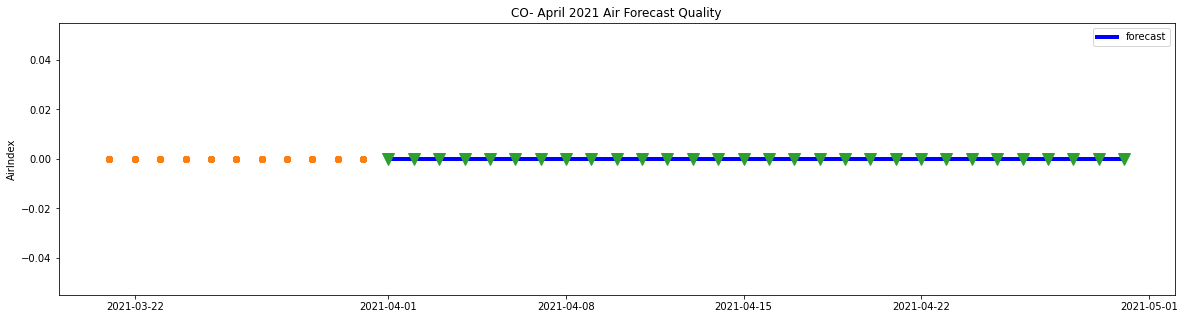

Air_Pressure total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.959793


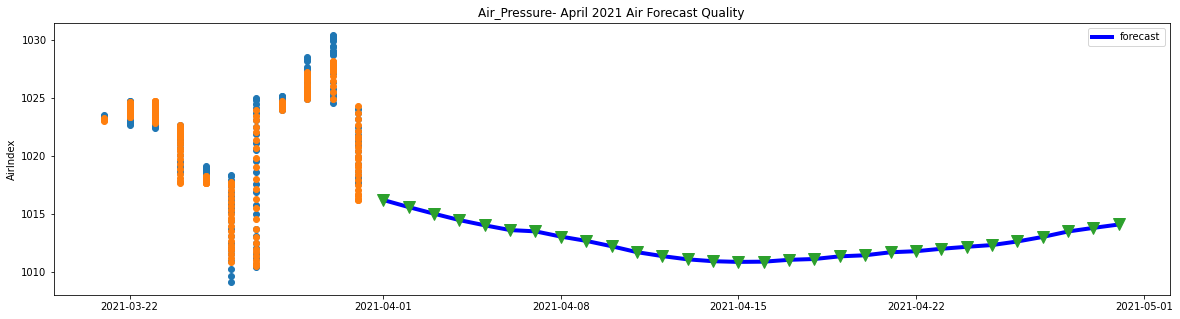

Ozone total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.659564


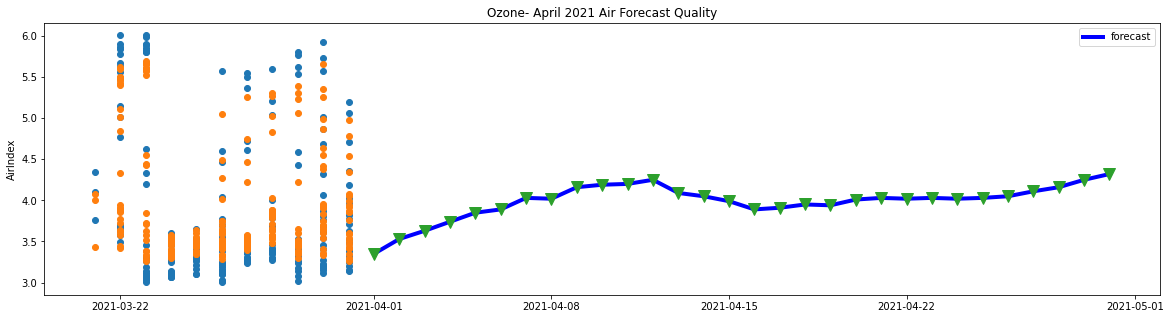

NO2 total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: -0.039714


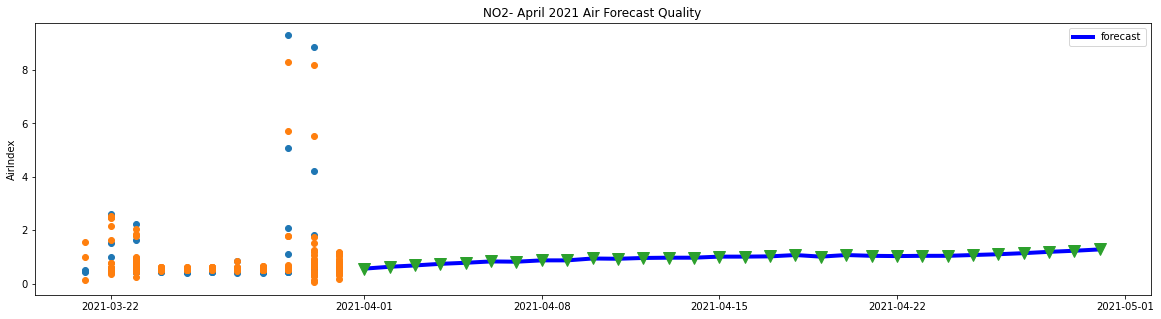

Virus_Index total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.562016


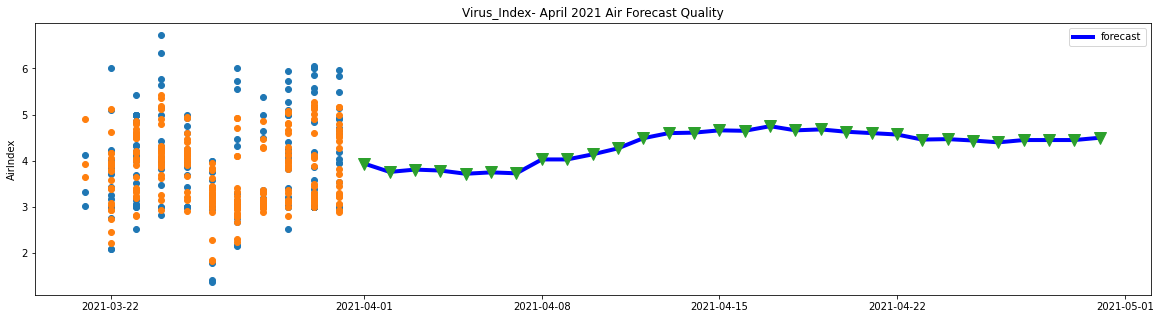

AQI_calculated total samples:  1364
Training samples:  1091
Testing samples:  273


/home/markn/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Test R-squared is: 0.384040


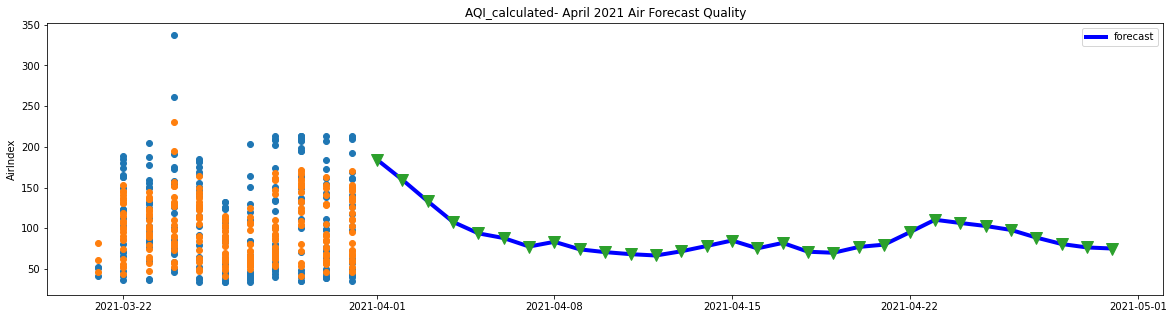

In [30]:
# Fitting and forecast using LSTM  -- output of train loss and valid loss is turned off
lstm_prediction = index_air_lstm(all_air_index,30,30)
## 7 is the number of day to be forecasting. 

From the above plots, the orange and blue points are the historical data values of all the air parameters while the green triangles are the predicted values.Following are the results from the above predictions:

1. **Temperature**= Show good future prediction in 1 month with 0.81 of R-Squared.

2. **Relative Humiditiy**= show good future predictio of 1 month with 0.91 % being correctly classified.

3. **TVOC**= Show as 0.55 of R-Squared. 

4. **CO2**= Show the result with 0.51 it is normal number. Obviously, this point is not high number

5. **Air_Pressure**= Show good result of prediction data in 1 month with 0.95 as high the trend is going to be smooth down and balance upper way ahead at the end of the month. 

6. **Ozone**= Show the result of R-square is around 0.660858 which quite not so high. As it comtemplate for weather forcast. 100% it won't be high accuracy due to different impact of Data and outside factor might impact into the different index such as rain, fire, or pollution level. 

7. **AQI_Calculated**= we have R-square 0.406 which forcast the future of Air Quality Index is smaller and more fluctuate in the future 30 days. 

Since most of the values of r2_score are from 0.55 and above we can positively, use these values as predictions as the high number of prediction states that the chances of error are comparatively lower. Although, AQI_calculated has a lower value of 0.40, this indicates that the predictions can be improved and tuned further.

**The idea is we took only the high R-square feature from each model SVM and LSTM export to CSV, and pickup the high level of each different model in 2 method and merge them together to give the right outcome with maximum level of prediction result.**


# Conclusion

In this notebook, interesting differences were observed while forecasting daily temperatures using the two models. The SVR model was able to capture the daily fluctuations in greater detail which looked more real compared to the forecast returned by the LSTM model, as observed from the forecast plots. Besides, the total run time for the SVR model for fitting the data was only a few minutes and was far less than the time taken by the LSTM model, which was training for 100 epochs for each station.

Similarly, a timeseries air-quality-index dataset was used to predict daily of different air index for Sensor in Eco-village for the month of Febuary using historic data from 5-7 different air index. Some instances of low accuracy for both the models were caused for certain stations due to less training data points available.



# Explore Data Analysis of Prediction
After we have predicted the values of Air Quality Index using both algorithms. For this, the SVR model will be used, we'll be using the values stored in the dataset Export_DataFrame. Lets plot their values 

In [31]:
# svr_prediction.to_csv('Export_DataFrame.CSV')
prediction = pd.read_csv('/home/markn/Desktop/DataSensor/Export_DataFrame.csv')

After exporting, to fix the collumn date index without date_name from excel. It import the same file to have the visulization of prediction EDA stored in the pivot table data_df_heat_map.

In [32]:
data_df_heat_map = prediction.pivot_table(index='Date').fillna(0)

# Select columns to use, optionally subset or use relative numbers
data_df_heat_map = data_df_heat_map[data_df_heat_map.columns[0:24]]

# Show the tail of the data. 
data_df_heat_map.tail(5).loc[::-1].transpose() 

Date,2021-04-19,2021-04-18,2021-04-17,2021-04-16,2021-04-15
AQI_calculated,80.25,67.21,78.39,75.53,63.01
Air_Pressure,1020.74,1020.95,1021.15,1021.41,1021.70
CO,0.00,0.00,0.00,0.00,0.00
CO2,575.94,573.91,631.31,652.88,655.82
NO2,0.51,0.47,0.45,0.65,0.72
Ozone,3.42,3.34,3.41,3.49,3.48
PM25,2.25,2.21,2.56,2.28,1.54
Relative_Humidity,27.91,27.83,27.87,27.52,27.50
TVOC,7.88,18.68,99.49,186.95,241.43
Temperature,23.84,24.23,24.57,24.77,24.88


The code support the original data transform a pivot_table where the air_index title stay on the left side. And Date convert to columns for each prediction day. 

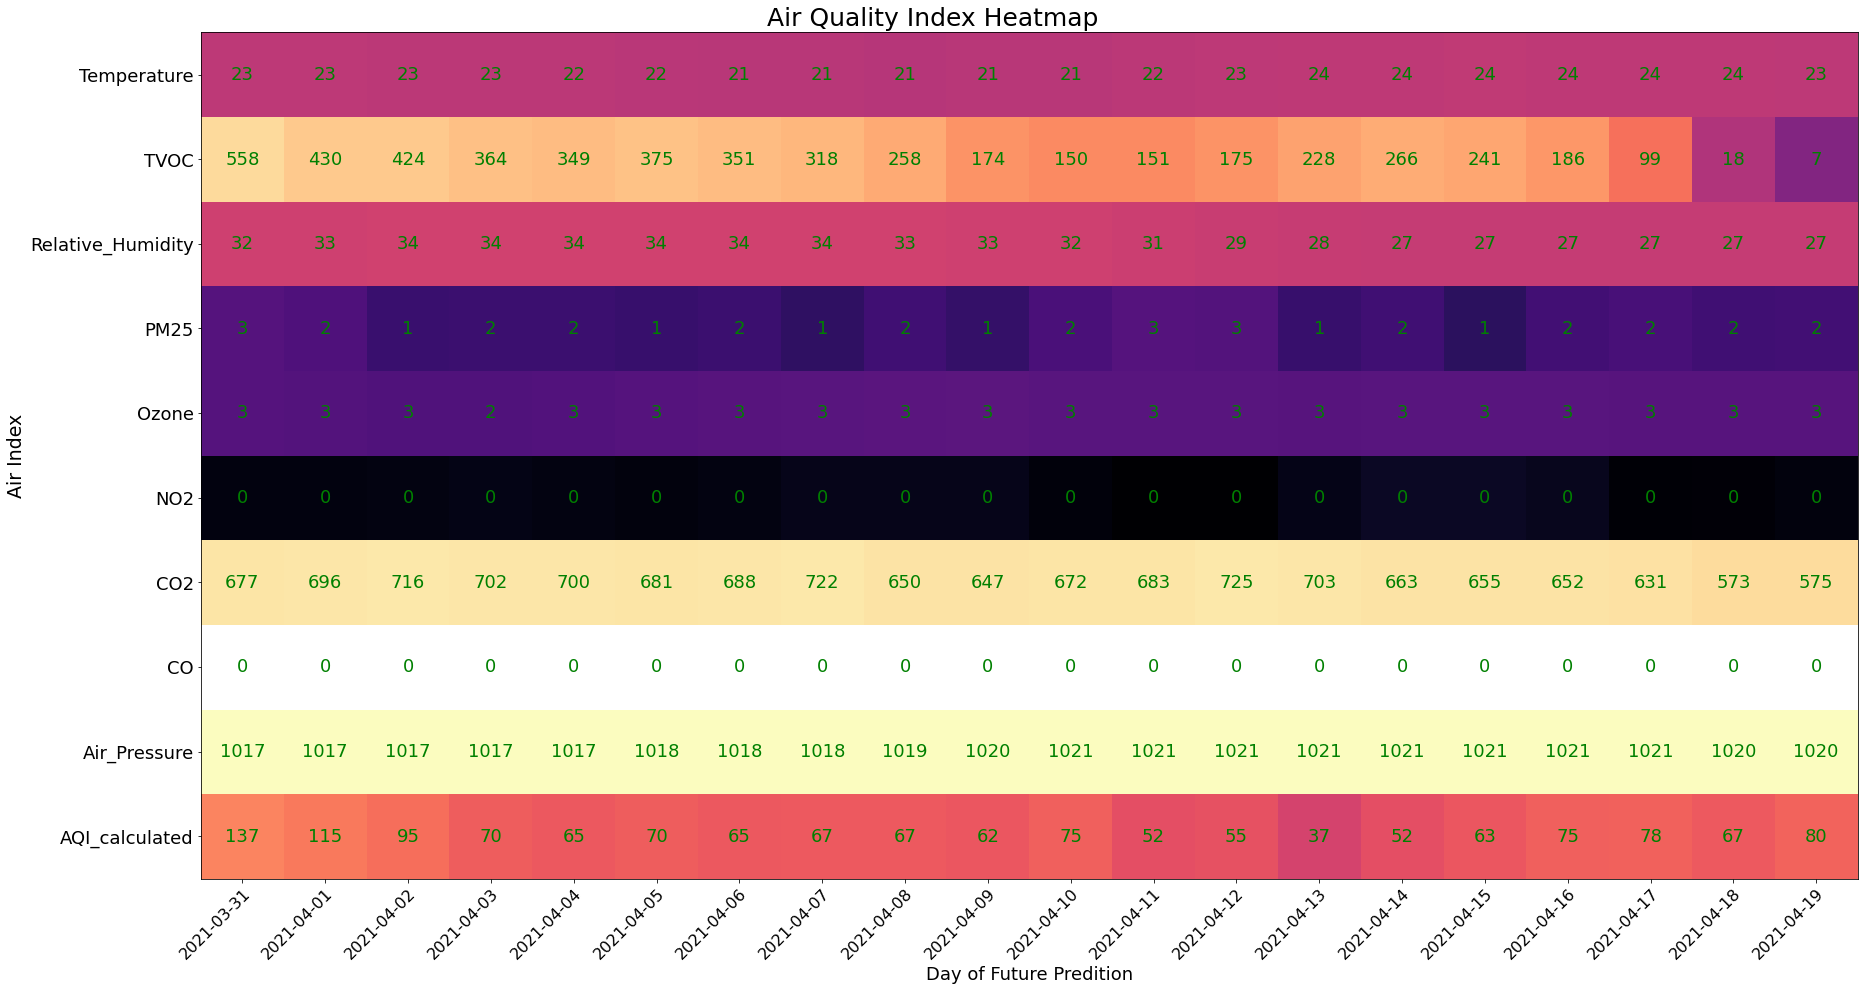

In [33]:
## Define array of row and columns headers 
durationsperday = data_df_heat_map.index 
air_index = data_df_heat_map.columns 

## Output size to modified with data size and length 
fig, ax = plt.subplots(figsize=(26,14))

heatmap = plt.imshow(
    np.log(data_df_heat_map[data_df_heat_map > 0].loc[:].transpose()), 
    cmap='magma', 
    interpolation='None', 
    aspect='auto', 
    origin='lower')

# Value add to be axis tick label
ax.set_xticks(np.arange(len(durationsperday)))
ax.set_yticks(np.arange(len(air_index)))
# set the label for duration per day, and air_index. 
ax.set_xticklabels(durationsperday)
ax.set_yticklabels(air_index)

# X labels diagonally
plt.setp(
    ax.get_xticklabels(), 
    rotation=45, 
    ha="right", 
    rotation_mode="anchor", 
    size=16)

# Y labels diagonally
plt.setp(
    ax.get_yticklabels(), 
    size=18)

# Convert dataframe to numpy dataframe
np_heat = data_df_heat_map.to_numpy() 

# Set numbers as text labels 
for i in range(len(durationsperday)): 
    for j in range(len(air_index)): 
        text = ax.text(
            i, 
            j, 
            int(np_heat[i, j]), 
            ha="center", 
            va="center", 
            color="g", 
            size=18)
            
fig.suptitle('Air Quality Index Heatmap', fontsize=25)
plt.xlabel('Day of Future Predition', fontsize=18)
plt.ylabel('Air Index', fontsize=19)
fig.tight_layout() 
plt.show() 

The above heatmap illustrates the values of different air parameters index and Air Quality Index Values.
It supports the user clearly understand how the values change.
It clearly shows the different index and number for each single day performance follow the prediction data. 
* We have NO and CO is always zero of future prediction due to the original data. Because the sensor is located inside therefore the number of NO2 and CO is quite stable with Zero. 
* We have the future of Air Quality Index show in the last line where it is quite okay in the 2021-03-31. 
* Temperature quite balance between 23 and 24.
* CO2 stays gradually in the range of 677 and 700 mg / m3 (milligrams per cubic meter of air).  
* Relative_Humidity are well *performing* in the future. 

More analysis of the predicted values has been carried out in the Exploratory Data Analysis file.

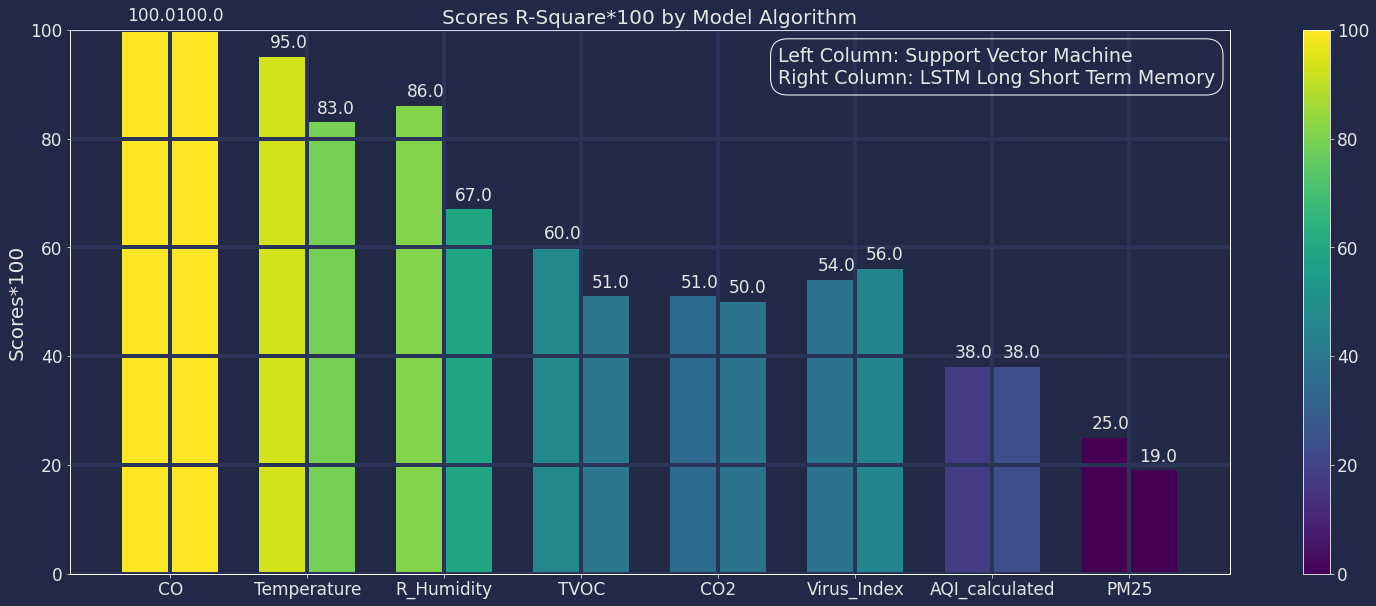

In [207]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import warnings

warnings.simplefilter('ignore')

plt.style.use("dark_background")
# plt.style.use("Solarize_Light2")
for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey


labels = [ 'CO', 'Temperature', 'R_Humidity', 'TVOC', 'CO2', 'Virus_Index','AQI_calculated', 'PM25']
SVM = [100, 95, 86, 60, 51, 54, 38, 25]
LSTM_model = [100, 83, 67, 51, 50,56,  38, 19]

my_cmap = plt.get_cmap("viridis")
rescale = lambda LSTM_model: (LSTM_model - np.min(LSTM_model)) / (np.max(LSTM_model) - np.min(LSTM_model))
rescale1 = lambda SVM: (SVM - np.min(SVM)) / (np.max(SVM) - np.min(SVM))
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, SVM, width, label='LSTM: Long short term memory', color=my_cmap(rescale1(SVM)))
rects2 = ax.bar(x + width/2, LSTM_model, width, label='SVR: Support Vector Regression', color=my_cmap(rescale(LSTM_model)))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores*100', size=20)
ax.set_title('Scores R-Square*100 by Model Algorithm', size=20)
ax.set_xticks(x)
# ax.set_xticklabels(labels)

# legend = ax.legend(bbox_transform=fig.transFigure)

ax.annotate("Left Column: Support Vector Machine\nRight Column: LSTM Long Short Term Memory",
            xy=(0.61,0.9), xycoords='axes fraction',
            textcoords='offset points',
            size=19,
            bbox=dict(facecolor='none', edgecolor='white', boxstyle="round,pad=0.4,rounding_size=0.9"))

######

ax.set_xticklabels(labels)

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(5, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

plt.rcParams.update({'font.size': 17})
plt.rcParams["figure.figsize"] = (26,10)

ax.set_ylim([0, 100])

legend.legendHandles[0].set_color('green')
legend.legendHandles[1].set_color('yellow')

# plt.suptitle(title_string, y=1.05, fontsize=18)

ax.patch.set_edgecolor('white')  

ax.patch.set_linewidth('1') 

ax.grid(color='#2A3459', linestyle='-', linewidth=4)

ax, _ = mpl.colorbar.make_axes(plt.gca(), shrink=1)

cbar = mpl.colorbar.ColorbarBase(ax, cmap=my_cmap,
                       norm=mpl.colors.Normalize(vmin=0, vmax=100))

plt.show()

# Conclustion of Model 

It also related with the tail of **Normalization** graph at violin plot that express above in this notebook. 

All number and index are affect from how violin shape express and the lenght of tail. 

`CO` <span style="color:green"> Result alway bring the high score is 100 with the reason is from the original data it has Zero. 
Carbonic might be a reason get high inside of the house because the fire or any action which lead to higher CO can be happend during daily life. Such as Cook, Machine of Car is running. </span>

`Temperature` <span style="color:green">  Success to bring the high result of prediction in LSTM we have 83 and SVM we have 95. With the reason behind it is less fluctuate. The balance from the tail and it's shape from normalization graph is stable therefor the number wasn't jump and changing in large vibration between each day or each hour. The violin tail from Normalization graph does beutiful shape that why it also impact into the prediction quality. </span>

`Relative_Humidity` <span style="color:blue"> are  good result of future number which lead to 86 score in SVM and 67 in LSTM. They are reliable data from the original data. Therefor the 3st index are high result of prediction. </span> 

`TVOC` <span style="color:blue"> give quite normal result with 60 in SVM and 51 LSTM. In real project we are not realy focus on the TVOC ( In other way, fraction of data may lead to some understanding of Polution level base on TVOC, CO2, Virus_index) </span>

`CO2` <span style="color:blue"> happened with 51 is SVM and 50 in LSTM. It was quite normal prediction. </span>

`Virus_index` it does increase a bit of Score in Virus and it over 50 score. Therefor we should adjust the score might be better in future if we can collect more data from the past. The more data we are collected the more we can make the score is better. 

`Air_Quality` in the tail of Normalization graph violin shape are not beutiful which mean volatility index is high. The number of prediction follow high volatility  which does not make a well prediction score. 

`PM25` has the long tail in it's own shape of violin body. Which relate to lower prediction number. 

## Advice to improve the model to have better solution in time-series. 


<center><img src='https://user-images.githubusercontent.com/50198601/121797864-42b4d100-cc23-11eb-8ab7-c681cef098ec.PNG' ></center>


**According to the research, we have form and make another extra notebook of prediction that applies a multi-model prediction algorithm as the test case with AR LSTM, CNN, Base-Line Model, RNN, Last Step, Linear Model. They are generated quite a reliable result with an overall  > 70 of MAE score number**

In this notebook, we do well-performance for the AQI index. The extra fact that in our vision, we should have further consideration in multiple algorithms. Then we make another notebook which not includes here. With the right approach, the multiple algorithm performance. If we added them in, it might lead to some redundancy of work. Nevertheless, it might help readers clear the future of applied AI into air forecast. And we do have better results of prediction during daily hours. 

_Here is some result from another extra notebook as experience_ 

<center><img src='https://user-images.githubusercontent.com/50198601/121816555-9dc6e200-cc7c-11eb-9bbe-105f4f8ae33f.PNG' ></center>


LSTM does well on deep history data with more data from the past, the more we might come out with high accuracy. 

SVM does well on short-term history data with support vector-based on the Regression model. 

Another algorithm does well performance is Last: 

`Last`    : 0.8489

`Repeat`  : 0.7280

`Linear`  : 0.7865

`Dense`   : 0.7778

`Conv`    : 0.7779

`LSTM`    : 0.7793

`AR LSTM` : 0.7366


__`Future thought` : Index-forecast will be the interest field, and its algorithm will influence weather station. Big data weather will do a good job on future prediction.__

__Our solution will connect with application which is a web applicaion and forcast for 7 days applied. 
By export data of 7 days prediction in Json file and work with Blazor Dashboard: https://github.com/MarkRichers/IntProject_ECOVillageAI we will public our extra prediction notebook in here.__

<center><img src="https://mir-s3-cdn-cf.behance.net/project_modules/disp/421f0c16071075.562a500e6ddd4.gif" alt="Alt text that describes the graphic" title="Title text" /></center>



